# 만들어진 Doc2Vec model을 통한 감정분석 실시
> * Positive or Negative

In [3]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

from sklearn.preprocessing import scale
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils

import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/hyunyoun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
def Make_Roc_Curve(x, y, model1, model2, model3):
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [7]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [8]:
import gensim
gensim.__version__

'3.3.0'

* windows에서 모델을 만들때 사용한 gensim의 버전이 3.3이었고, mac에서는 버전이 맞지 않아서 만들어둔 모델을 불러오지 못하였음.

## Doc2Vec

In [9]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [10]:
def Get_Infer_Vector(docs, model):
    return [model.infer_vector(doc.words) for doc in tqdm(docs)]

In [11]:
loadModelPath = '/Volumes/disk1/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

### twitter

#### Load Model

In [363]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

#### Word to Vector

##### train set

In [375]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_by_ct_train.pickled','rb'))

In [377]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_y_ct_for_sentiment_analysis'):
    train_y = [doc.tags[0] for doc in tqdm(train)]

    pickle.dump(train_y, open(saveTrainPath+'train_y_ct_for_sentiment_analysis','wb'))
    del train_y

if 'train' in locals():
    del train

100%|██████████| 100/100 [00:00<00:00, 11791.03it/s]


##### test set

In [378]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_by_ct_test.pickled','rb'))

In [380]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_y_ct_for_sentiment_analysis'):
    test_y = [doc.tags[0] for doc in tqdm(test)]

    pickle.dump(test_y, open(saveTrainPath+'test_y_ct_for_sentiment_analysis','wb'))
    del test_y

if 'test' in locals():
    del test

100%|██████████| 10/10 [00:00<00:00, 2242.58it/s]


#### model1
* Doc2Vec(dm/m,d2000,n7,w10,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [162]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_ct_for_sentiment_analysis','rb'))

In [163]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [164]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m1, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m1)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.62
classification report
             precision    recall  f1-score   support

          0       0.68      0.56      0.61        54
          1       0.57      0.70      0.63        46

avg / total       0.63      0.62      0.62       100



In [165]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [166]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m1, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.55
classification report
             precision    recall  f1-score   support

          0       0.57      0.67      0.62        54
          1       0.51      0.41      0.46        46

avg / total       0.54      0.55      0.54       100



In [167]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [168]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m1, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m1)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.65
classification report
             precision    recall  f1-score   support

          0       0.70      0.61      0.65        54
          1       0.60      0.70      0.65        46

avg / total       0.66      0.65      0.65       100



In [169]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

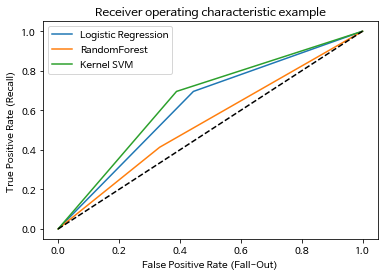

In [170]:
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3)

In [171]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [172]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 391113.76it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 196915.68it/s]


In [173]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.7880
Accuracy: 0.6250


In [174]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

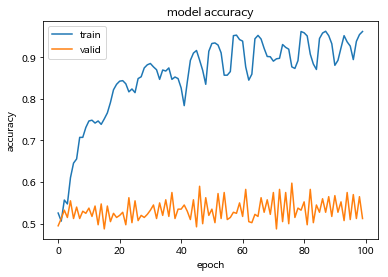

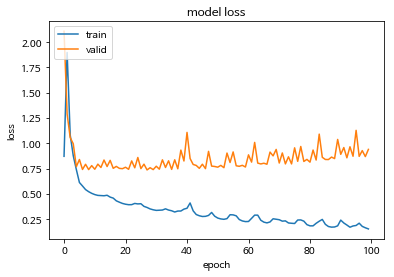

In [175]:
plot_history(history)

In [176]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.8921
Accuracy: 0.6900


In [177]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

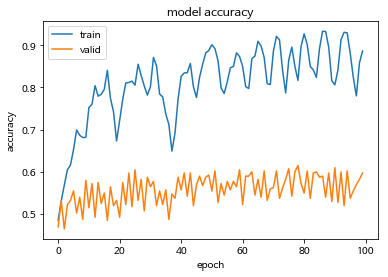

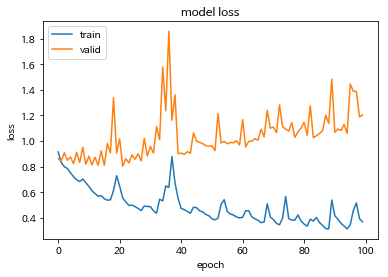

In [178]:
plot_history(history)

In [179]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 1.4027
Accuracy: 0.5800


In [180]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m1_name)

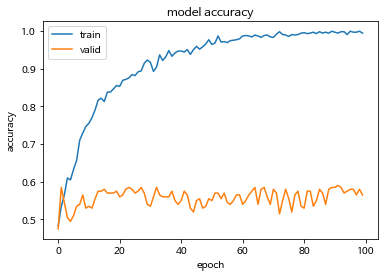

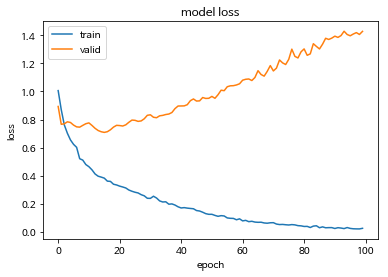

In [181]:
plot_history(history)

In [182]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

(1000, 2000, 1) (100, 2000, 1)


In [183]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.6761
Accuracy: 0.5900


In [184]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m1_name)

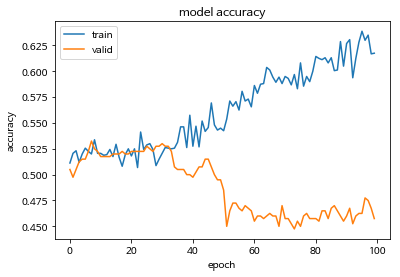

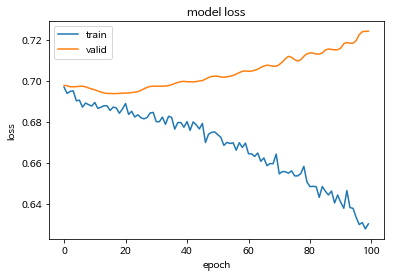

In [185]:
plot_history(history)

In [186]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d2000,n7,w5,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [187]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_ct_for_sentiment_analysis','rb'))

In [188]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [189]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m2, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m2)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.57
classification report
             precision    recall  f1-score   support

          0       0.61      0.57      0.59        54
          1       0.53      0.57      0.55        46

avg / total       0.57      0.57      0.57       100



In [190]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [191]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m2, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.46
classification report
             precision    recall  f1-score   support

          0       0.50      0.61      0.55        54
          1       0.38      0.28      0.33        46

avg / total       0.45      0.46      0.45       100



In [192]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [193]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m2)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.58
classification report
             precision    recall  f1-score   support

          0       0.77      0.31      0.45        54
          1       0.53      0.89      0.66        46

avg / total       0.66      0.58      0.55       100



In [194]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

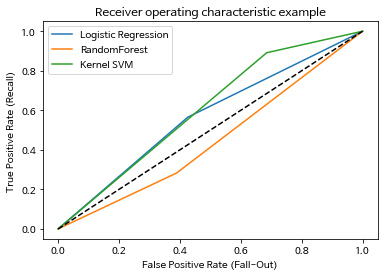

In [195]:
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3)

In [196]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [197]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 408204.77it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 181101.21it/s]


In [198]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.8285
Accuracy: 0.5300


In [199]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

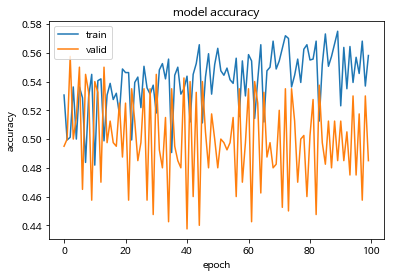

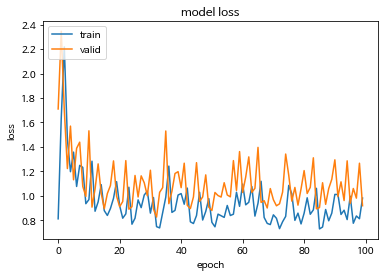

In [200]:
plot_history(history)

In [201]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.7644
Accuracy: 0.5900


In [202]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

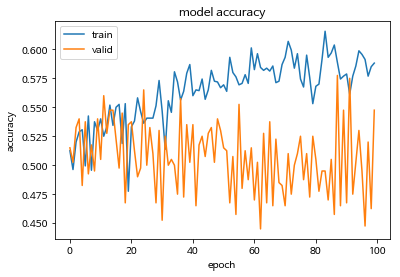

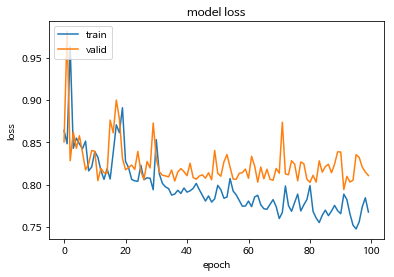

In [203]:
plot_history(history)

In [204]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.7159
Accuracy: 0.5300


In [205]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m2_name)

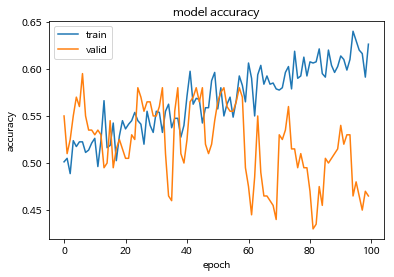

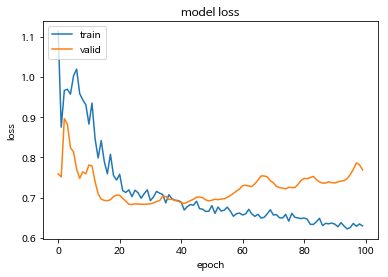

In [206]:
plot_history(history)

In [207]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

(1000, 2000, 1) (100, 2000, 1)


In [208]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.6739
Accuracy: 0.5450


In [209]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m2_name)

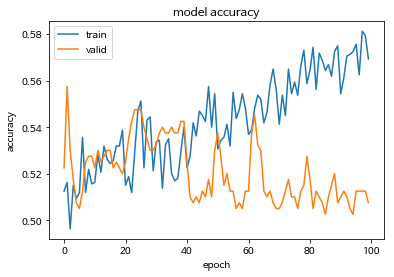

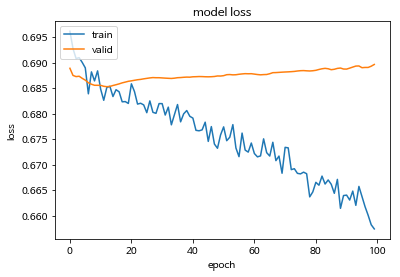

In [210]:
plot_history(history)

In [211]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

#### model3
* Doc2Vec(dbow,d2000,n7,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [212]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_ct_for_sentiment_analysis','rb'))

In [213]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [214]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.79
classification report
             precision    recall  f1-score   support

          0       0.80      0.81      0.81        54
          1       0.78      0.76      0.77        46

avg / total       0.79      0.79      0.79       100



In [215]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [216]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.59
classification report
             precision    recall  f1-score   support

          0       0.60      0.70      0.65        54
          1       0.57      0.46      0.51        46

avg / total       0.59      0.59      0.58       100



In [217]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [218]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m3, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.73
classification report
             precision    recall  f1-score   support

          0       0.76      0.72      0.74        54
          1       0.69      0.74      0.72        46

avg / total       0.73      0.73      0.73       100



In [219]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

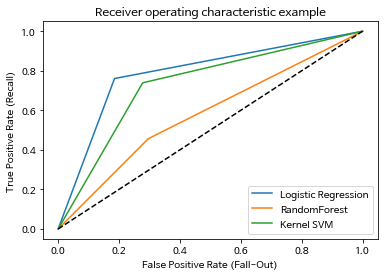

In [220]:
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3)

In [221]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [222]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 313780.50it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 306601.17it/s]


In [223]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.9425
Accuracy: 0.7500


In [224]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

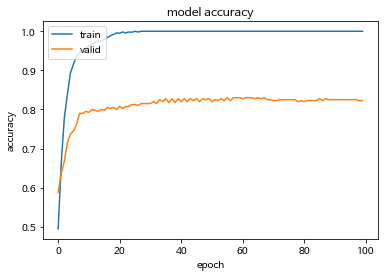

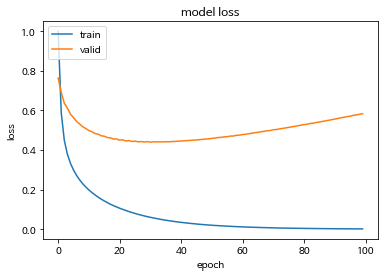

In [225]:
plot_history(history)

In [226]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 1.0740
Accuracy: 0.7300


In [227]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

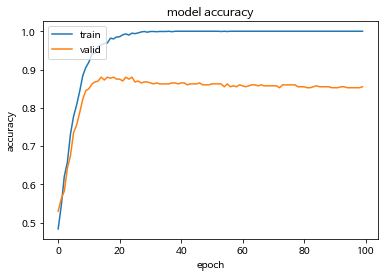

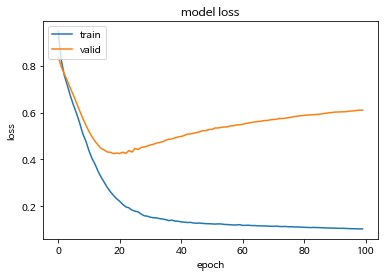

In [228]:
plot_history(history)

In [229]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 1.0993
Accuracy: 0.7300


In [230]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m3_name)

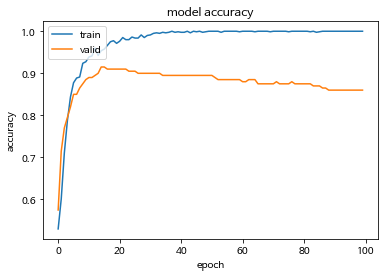

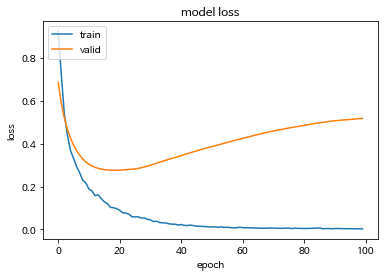

In [231]:
plot_history(history)

In [232]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

(1000, 2000, 1) (100, 2000, 1)


In [233]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.7239
Accuracy: 0.5800


In [234]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

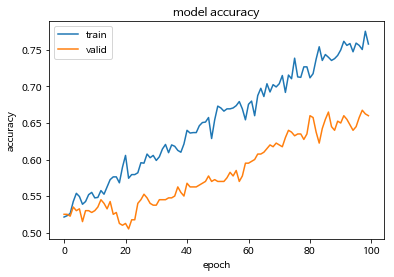

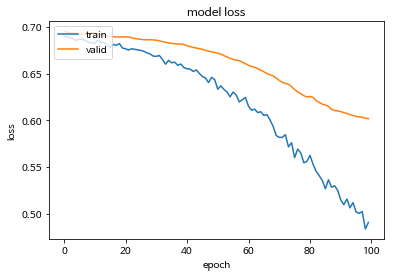

In [235]:
plot_history(history)

In [236]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name

#### mecab

#### Load Model

In [381]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

#### Word to Vector

##### train set

In [382]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_by_mecab_train.pickled','rb'))

In [385]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_y_mecab_for_sentiment_analysis'):
    train_y = [doc.tags[0] for doc in tqdm(train)]

    pickle.dump(train_y, open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','wb'))
    del train_y

if 'train' in locals():
    del train

100%|██████████| 100/100 [00:00<00:00, 3947.73it/s]


##### test set

In [386]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_by_mecab_test.pickled','rb'))

In [388]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_y_mecab_for_sentiment_analysis'):
    test_y = [doc.tags[0] for doc in tqdm(test)]

    pickle.dump(test_y, open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','wb'))
    del test_y

if 'test' in locals():
    del test

100%|██████████| 10/10 [00:00<00:00, 2206.95it/s]


#### model1
* Doc2Vec(dm/m,d2000,n7,w10,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [274]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','rb'))

In [275]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-mecab'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [276]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m1, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m1)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.66
classification report
             precision    recall  f1-score   support

          0       0.68      0.70      0.69        54
          1       0.64      0.61      0.62        46

avg / total       0.66      0.66      0.66       100



In [277]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [278]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m1, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.57
classification report
             precision    recall  f1-score   support

          0       0.58      0.72      0.64        54
          1       0.55      0.39      0.46        46

avg / total       0.57      0.57      0.56       100



In [279]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [280]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m1, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m1)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.67
classification report
             precision    recall  f1-score   support

          0       0.69      0.70      0.70        54
          1       0.64      0.63      0.64        46

avg / total       0.67      0.67      0.67       100



In [281]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

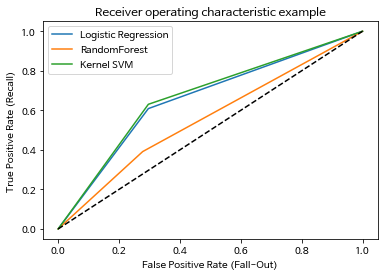

In [282]:
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3)

In [283]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [284]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 384904.47it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 116832.98it/s]


In [285]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.7763
Accuracy: 0.6150


In [286]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

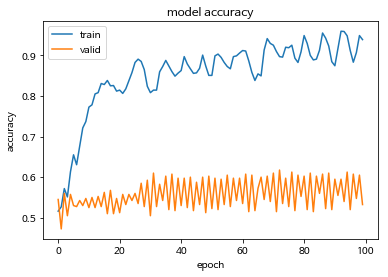

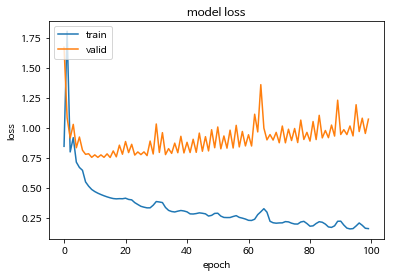

In [287]:
plot_history(history)

In [288]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.9591
Accuracy: 0.6350


In [289]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

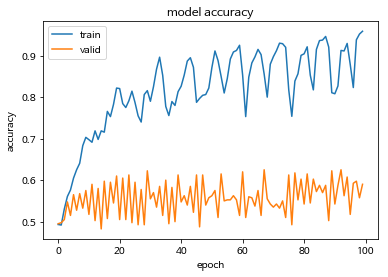

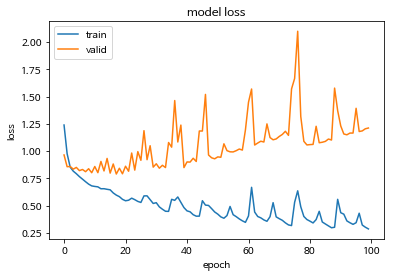

In [290]:
plot_history(history)

In [291]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.8528
Accuracy: 0.6400


In [292]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m1_name)

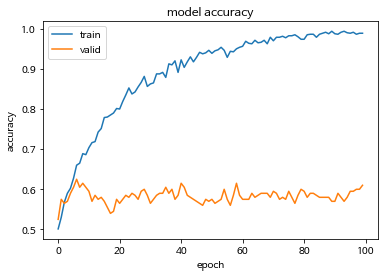

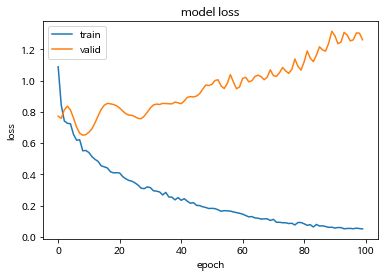

In [293]:
plot_history(history)

In [294]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

(1000, 2000, 1) (100, 2000, 1)


In [295]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.6550
Accuracy: 0.5750


In [296]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m1_name)

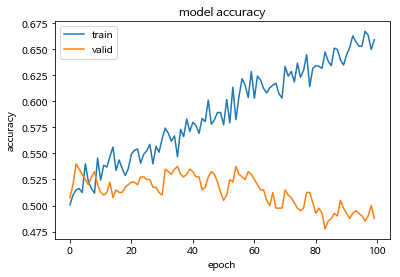

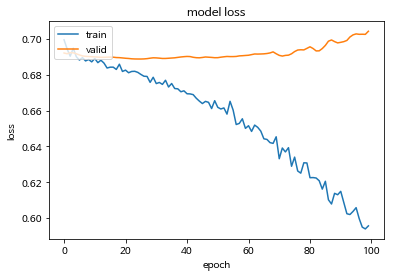

In [297]:
plot_history(history)

In [298]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d2000,n7,w5,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [299]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','rb'))

In [300]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [301]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m2, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m2)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.48
classification report
             precision    recall  f1-score   support

          0       0.52      0.44      0.48        54
          1       0.44      0.52      0.48        46

avg / total       0.49      0.48      0.48       100



In [302]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [303]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m2, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.53
classification report
             precision    recall  f1-score   support

          0       0.56      0.61      0.58        54
          1       0.49      0.43      0.46        46

avg / total       0.53      0.53      0.53       100



In [304]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [305]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m2)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.51
classification report
             precision    recall  f1-score   support

          0       0.53      0.93      0.67        54
          1       0.20      0.02      0.04        46

avg / total       0.38      0.51      0.38       100



In [306]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

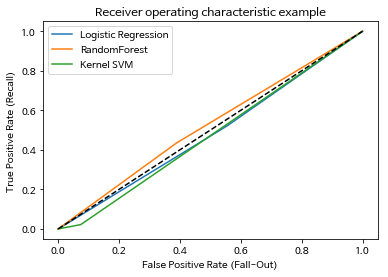

In [307]:
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3)

In [308]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [309]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 557679.03it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 307725.90it/s]


In [310]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.8867
Accuracy: 0.4550


In [311]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

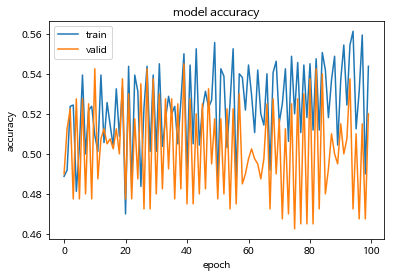

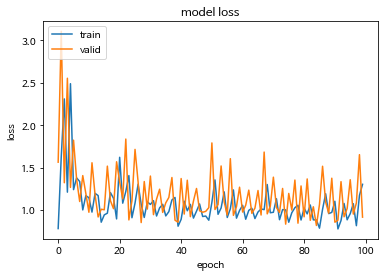

In [312]:
plot_history(history)

In [313]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.7797
Accuracy: 0.5150


In [314]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

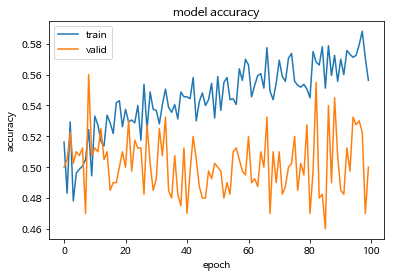

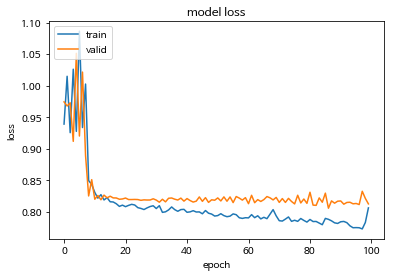

In [315]:
plot_history(history)

In [316]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.6685
Accuracy: 0.5400


In [317]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m2_name)

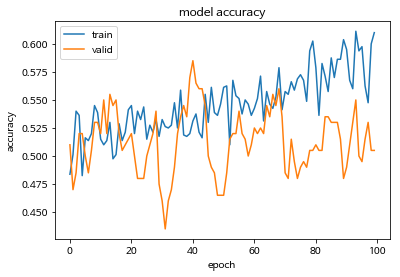

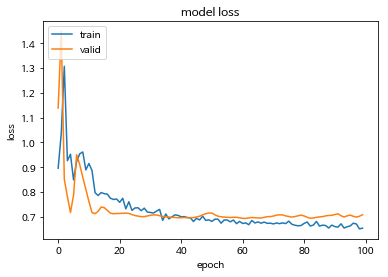

In [318]:
plot_history(history)

In [319]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

(1000, 2000, 1) (100, 2000, 1)


In [320]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.6622
Accuracy: 0.5700


In [321]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m2_name)

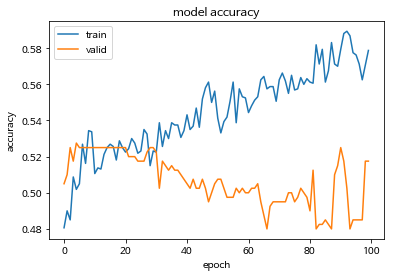

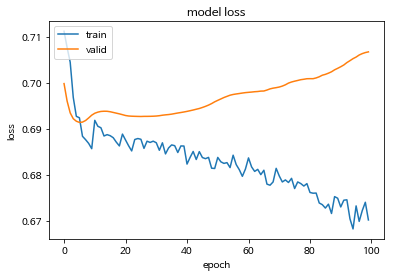

In [322]:
plot_history(history)

In [323]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name


#### model3
* Doc2Vec(dbow,d2000,n7,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [325]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-mecab'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','rb'))

In [326]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-mecab'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [327]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.78
classification report
             precision    recall  f1-score   support

          0       0.77      0.85      0.81        54
          1       0.80      0.70      0.74        46

avg / total       0.78      0.78      0.78       100



In [328]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [329]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.66
classification report
             precision    recall  f1-score   support

          0       0.66      0.78      0.71        54
          1       0.67      0.52      0.59        46

avg / total       0.66      0.66      0.65       100



In [330]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [331]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m3, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.75
classification report
             precision    recall  f1-score   support

          0       0.76      0.78      0.77        54
          1       0.73      0.72      0.73        46

avg / total       0.75      0.75      0.75       100



In [332]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

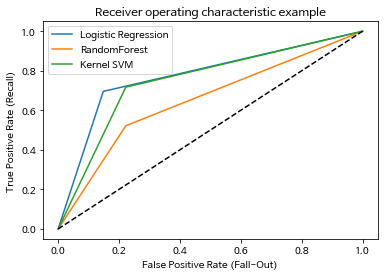

In [333]:
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3)

In [334]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [335]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 388505.37it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 171827.28it/s]


In [336]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=120), HTML(value='')))


Score: 2.5749
Accuracy: 0.7150


In [337]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

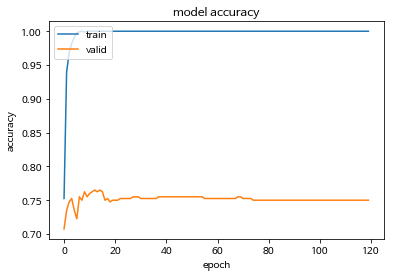

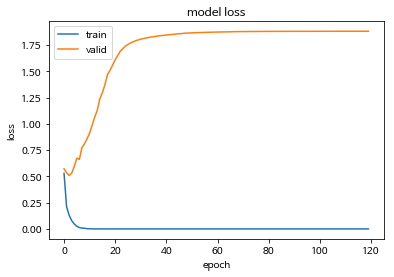

In [338]:
plot_history(history)

In [339]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 1.0882
Accuracy: 0.7500


In [340]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

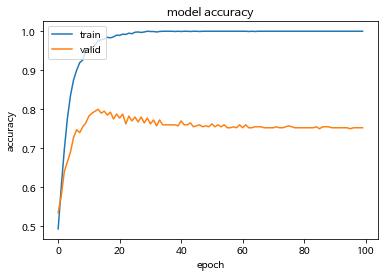

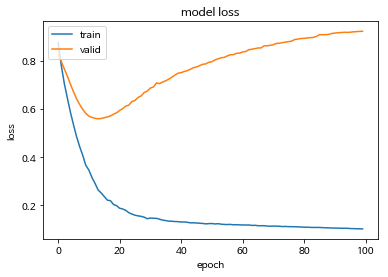

In [341]:
plot_history(history)

In [344]:
mode2 = Sequential()
mode2.add(Dense(64, activation='relu', input_dim=2000))
mode2.add(Dropout(0.25))
mode2.add(Dense(32, activation='relu'))
mode2.add(Dropout(0.125))
mode2.add(Dense(2, activation='softmax'))
mode2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = mode2.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = mode2.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 1.0261
Accuracy: 0.7300


In [345]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

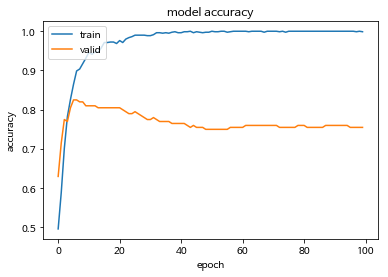

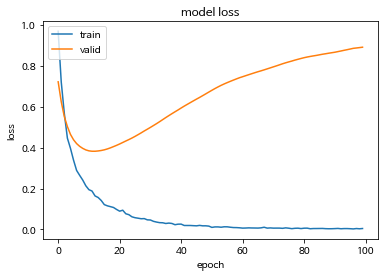

In [346]:
plot_history(history)

In [347]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

(1000, 2000, 1) (100, 2000, 1)


In [348]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))


Score: 0.5993
Accuracy: 0.6750


In [349]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

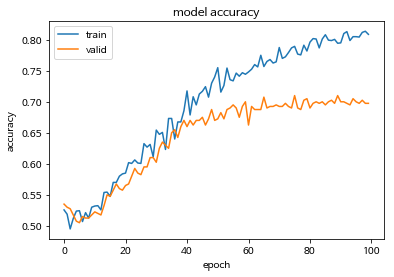

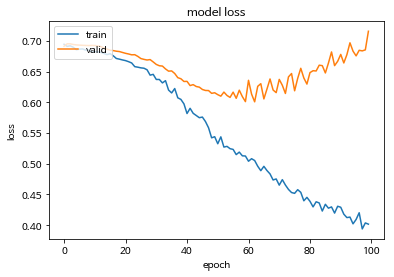

In [350]:
plot_history(history)

In [351]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name